# Getting Started with Ergodic Insurance Framework

## Verify Installation

In [1]:
# test_installation.py
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator
from ergodic_insurance.config_v2 import ManufacturerConfig

print("✅ Framework imported successfully!")

# Create configuration
config = ManufacturerConfig(
    initial_assets=10_000_000,
    asset_turnover_ratio=1.0,
    base_operating_margin=0.08,
    tax_rate=0.25,
    retention_ratio=0.7
)

# Create a simple manufacturer
company = WidgetManufacturer(config)

print(f"✅ Created company with ${company.assets:,.0f} in assets")
print("🎉 Installation successful!")

✅ Framework imported successfully!
✅ Created company with $10,000,000 in assets
🎉 Installation successful!


## Your First Simulation

### Step 1: Create the Basic Setup

In [7]:
# first_simulation.py
import numpy as np
import matplotlib.pyplot as plt
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator
from ergodic_insurance.config_v2 import ManufacturerConfig

# Set random seed for reproducibility
np.random.seed(42)

# Configure the manufacturer
config = ManufacturerConfig(
    initial_assets=10_000_000,    # Starting with $10M
    asset_turnover_ratio=1.0,     # Generate revenue equal to assets
    base_operating_margin=0.12,        # Profit margin before losses (~8% margin after losses)
    tax_rate=0.25,                # 25% corporate tax
    retention_ratio=0.7           # Retain 70% of earnings
)

# Create a $10M widget manufacturer
manufacturer = WidgetManufacturer(config)

print(f"Company Profile:")
print(f"  Initial Assets: ${manufacturer.assets:,.0f}")
print(f"  Expected Annual Revenue: ${manufacturer.assets * config.asset_turnover_ratio:,.0f}")
print(f"  Expected Operating Income (Before Losses): ${manufacturer.assets * config.asset_turnover_ratio * config.base_operating_margin:,.0f}")

Company Profile:
  Initial Assets: $10,000,000
  Expected Annual Revenue: $10,000,000
  Expected Operating Income (Before Losses): $1,200,000


### Step 2: Set Up Loss and Premium Parameters

In [8]:
scenarios = 100
years = 20
deductible = 100_000

# Loss Parameters
regular_freq_baseline = 2.0
regular_sev_mean = 80_000
regular_sev_std = 50_000

cat_freq_baseline = 0.1
cat_sev_mean = 2_000_000
cat_sev_std = 1_500_000

# For regular losses (mean $80K), most will be below $100K deductible
# Calculate expected excess for lognormal distribution

# Lognormal parameters for regular losses
variance = regular_sev_std ** 2
mean = regular_sev_mean

sigma = np.sqrt(np.log(1 + variance / mean**2))
mu = np.log(mean) - sigma**2 / 2

# Generate sample to estimate excess over deductible
regular_sample = np.random.lognormal(mu, sigma, 100_000)
regular_excess = np.maximum(0, regular_sample - deductible)
regular_excess_pure_premium = regular_excess.mean() * regular_freq_baseline

# For catastrophic losses (mean $2M), nearly all will exceed $100K deductible  
catastrophic_excess_pure_premium = (cat_sev_mean - deductible) * cat_freq_baseline

print(f"Baseline Revenue: {(config.initial_assets * config.asset_turnover_ratio):,.0f}")
print(f"Baseline Retained Losses: {(regular_sev_mean * regular_freq_baseline + cat_sev_mean * cat_freq_baseline - catastrophic_excess_pure_premium):,.0f}")

# Add expense loading
loss_ratio = 0.70
annual_premium_baseline = (regular_excess_pure_premium + catastrophic_excess_pure_premium) / loss_ratio

print(f"Baseline Annual Premium: {annual_premium_baseline:,.0f}")


Baseline Revenue: 10,000,000
Baseline Retained Losses: 170,000
Baseline Annual Premium: 305,311


### Step 3: Run the Simulation

In [10]:
bankruptcy_no_ins_scenarios = []
bankruptcy_with_ins_scenarios = []

scenarios_no_insurance = []
scenarios_with_insurance = []

for scen in range(scenarios):
    ### Configuration 1: No insurance #######
    all_scenario_claims_no_ins = []
    manufacturer_no_ins = WidgetManufacturer(config)
    wealth_no_insurance = [config.initial_assets]

    for year in range(years):
        revenue = manufacturer_no_ins.calculate_revenue()  # Current revenue
        revenue_scale = revenue / config.initial_assets

        # Regular losses: 4-6 per year on average, typically $50K-$150K
        regular_frequency = regular_freq_baseline * revenue_scale  # Scale with revenue
        regular_generator = ClaimGenerator(
            frequency=regular_frequency,
            severity_mean=regular_sev_mean,
            severity_std=regular_sev_std,
        )

        # Catastrophic losses: ~0.1 per year (once every 10 years), but can be $1M-$5M
        catastrophic_frequency = cat_freq_baseline * revenue_scale  # Also scales with revenue
        catastrophic_generator = ClaimGenerator(
            frequency=catastrophic_frequency,
            severity_mean=cat_sev_mean,
            severity_std=cat_sev_std,
        )

        # Generate regular losses for this year
        regular_claims, _ = regular_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False,
        )

        # Generate catastrophic losses for this year
        catastrophic_claims, _ = catastrophic_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False
        )

        # Combine all losses for this year
        year_claims = regular_claims + catastrophic_claims

        # For no insurance, company pays all losses over time without collateral
        for claim in year_claims:
            manufacturer_no_ins.process_uninsured_claim(claim.amount)

        manufacturer_no_ins.step()
        wealth_no_insurance.append(manufacturer_no_ins.assets)

    if manufacturer_no_ins.is_ruined:
        bankruptcy_no_ins_scenarios.append(scen)

    scenarios_no_insurance.append(wealth_no_insurance)

    ### Configuration 2: With insurance ($100K deductible, $200M limit) #######
    manufacturer_with_ins = WidgetManufacturer(config)
    wealth_with_insurance = [config.initial_assets]

    for year in range(years):
        revenue = manufacturer_with_ins.calculate_revenue()  # Current revenue
        revenue_scale = revenue / config.initial_assets

        # Regular losses: 4-6 per year on average, typically $50K-$150K
        regular_frequency = regular_freq_baseline * revenue_scale  # Scale with revenue
        regular_generator = ClaimGenerator(
            frequency=regular_frequency,
            severity_mean=regular_sev_mean,       # Mean claim size $80K
            severity_std=regular_sev_std,        # Moderate variation
        )

        # Catastrophic losses: ~0.1 per year (once every 10 years), but can be $1M-$5M
        catastrophic_frequency = cat_freq_baseline * revenue_scale  # Also scales with revenue
        catastrophic_generator = ClaimGenerator(
            frequency=catastrophic_frequency,
            severity_mean=cat_sev_mean,    # Mean catastrophic loss $2M
            severity_std=cat_sev_std,     # High variation - can reach $5M+
        )

        # Generate regular losses for this year
        regular_claims, _ = regular_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False,
        )

        # Generate catastrophic losses for this year
        catastrophic_claims, _ = catastrophic_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False
        )

        # Combine all losses for this year
        year_claims = regular_claims + catastrophic_claims

        # Process each claim through insurance
        for claim in year_claims:
            company_payment, insurance_payment = manufacturer_with_ins.process_insurance_claim(
                claim_amount=claim.amount,
                deductible_amount=100_000,
                insurance_limit=200_000_000
            )

        # Pay annual premium based on current revenue scale
        current_revenue = manufacturer_with_ins.calculate_revenue()
        revenue_scale = current_revenue / config.initial_assets
        annual_premium = annual_premium_baseline * revenue_scale
        manufacturer_with_ins.record_insurance_premium(annual_premium)

        manufacturer_with_ins.step()
        wealth_with_insurance.append(manufacturer_with_ins.assets)

    if manufacturer_with_ins.is_ruined:
        bankruptcy_with_ins_scenarios.append(scen)

    scenarios_with_insurance.append(wealth_with_insurance)

print(f"Bankruptcies (no insurance): {len(bankruptcy_no_ins_scenarios)}/{scenarios}")
print(f"Bankruptcies (with insurance): {len(bankruptcy_with_ins_scenarios)}/{scenarios}")

Company became insolvent - unsustainable payment burden: $7,074,637 payments vs $3,078,945 revenue (229.8% burden ratio)
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step


Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company became insolvent - unsustainable payment burden: $5,610,433 payments vs $4,654,290 revenue (120.5% burden ratio)
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step

Bankruptcies (no insurance): 35/100
Bankruptcies (with insurance): 0/100


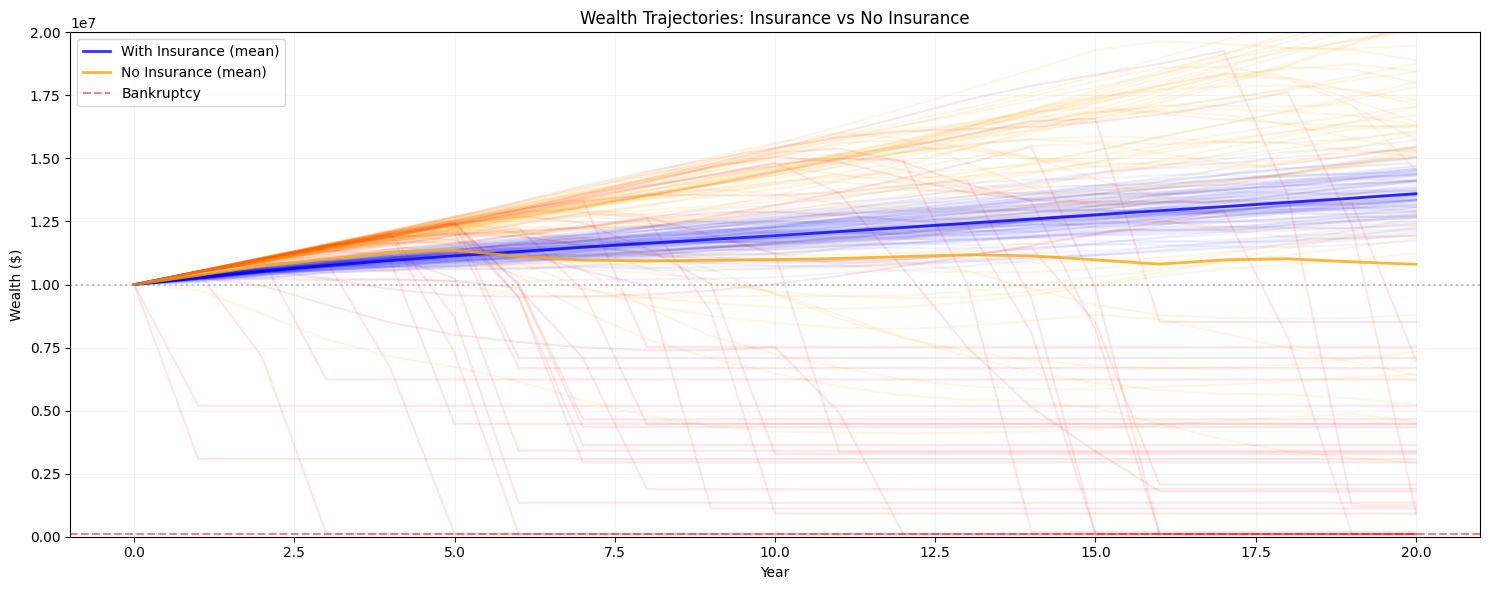

In [11]:
# Create comprehensive visualization
fig = plt.figure(figsize=(15, 6))

### Plot 1: Wealth trajectories comparison #######
ax1 = plt.subplot()

bankrupt_no_ins = []
bankrupt_with_ins = []

# Plot all scenarios
for idx, s in enumerate(scenarios_no_insurance):
    if idx in bankruptcy_no_ins_scenarios:
        ax1.plot(range(len(s)), s, color='red', alpha=0.1)
        bankrupt_no_ins.append(s)
    else:
        ax1.plot(range(len(s)), s, color='orange', alpha=0.1)
for idx, s in enumerate(scenarios_with_insurance):
    if idx in bankruptcy_with_ins_scenarios:
        bankrupt_with_ins.append(s)
    ax1.plot(range(len(s)), s, color='blue', alpha=0.05)

# Compute and overlay means
no_ins_mean = np.average(np.array(scenarios_no_insurance, dtype=float), axis=0)
with_ins_mean = np.average(np.array(scenarios_with_insurance, dtype=float), axis=0)

ax1.plot(range(len(with_ins_mean)), with_ins_mean, color='blue', linewidth=2, alpha=0.8, label='With Insurance (mean)')
ax1.plot(range(len(no_ins_mean)), no_ins_mean, color='orange', linewidth=2, alpha=0.8, label='No Insurance (mean)')
ax1.axhline(y=100_000, color='r', linestyle='--', alpha=0.5, label='Bankruptcy')
ax1.axhline(y=config.initial_assets, color='gray', linestyle=':', alpha=0.5)

ax1.set_xlabel('Year')
ax1.set_ylabel('Wealth ($)')
ax1.set_title('Wealth Trajectories: Insurance vs No Insurance')
ax1.set_ylim(0, 20_000_000)
ax1.legend()
ax1.grid(True, alpha=0.15)

plt.tight_layout()
plt.show()